In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker
import awkward as ak
import uproot 
import mplhep as hep
import hist
import os
import time
from numba import njit
from matplotlib.colors import LogNorm
import tqdm
import pickle 
from numba import jit



from UtilityAndConst import *
from Functions import *

dir = "/Users/francescolarovere/Documents/Tesi-Triennale/Dati"
os.chdir(dir)

hep.style.use("CMS")
np.set_printoptions(threshold=np.inf)

In [2]:
files = [
    "./ntupleStubsBmtfGmt_LS133.root",
    "./ntupleStubsBmtfGmt_LS263.root",
    "./ntupleStubsBmtfGmt_LS264.root",
    "./ntupleStubsBmtfGmt_LS306.root",
]

stub_bmtf_gmt_features = [
    'orbit', 'bx', 'nStubs', 'stubHwPhi', 'stubHwPhiB', 'stubHwQual', 'stubHwEta', 'stubHwQEta', 'stubStation', 'stubWheel', 'stubSector', 'stubTag',
    'nBmtfMuons', 'bmtfHwPt', 'bmtfHwPtu', 'bmtfHwPhi', 'bmtfHwEta', 'bmtfPt', 'bmtfPtu', 'bmtfPhi', 'bmtfEta', 'bmtfHwSign', 'bmtfHwSignValid', 'bmtfHwDXY', 'bmtfHwQual', 'bmtfProcessor', 
    'nGmtMuons', 'gmtHwPt', 'gmtHwPtu', 'gmtHwPhi', 'gmtHwEta', 'gmtHwPhiAtVtx', 'gmtHwEtaAtVtx', 'gmtPt', 'gmtPtu', 'gmtPhi', 'gmtEta', 'gmtPhiAtVtx', 'gmtEtaAtVtx', 'gmtCharge', 'gmtDxy', 'gmtQual', 'gmtTfIndex']

stub_bmtf_gmt_list = []
for file in files:
    with uproot.open(file) as f:
        evs = f["bmtfNtuplizer/Events"]
        temp_awk = evs.arrays(stub_bmtf_gmt_features, library="ak")
        stub_bmtf_gmt_list.append(temp_awk)
        
bmtf_gmt = ak.concatenate(stub_bmtf_gmt_list, axis=0)

In [3]:
#-----------------------------------------------Stubs------------------------------------------------
nStubs = bmtf_gmt.nStubs
stubsStation = bmtf_gmt.stubStation
stubsSector = bmtf_gmt.stubSector
stubsWheel = bmtf_gmt.stubWheel
stubsPhiB = bmtf_gmt.stubHwPhiB


#-----------------------------------------------BMTF------------------------------------------------
nBmtf = bmtf_gmt.nBmtfMuons
BmtfPhi = bmtf_gmt.bmtfPhi
BmtfEta = bmtf_gmt.bmtfEta
BmtfPt = bmtf_gmt.bmtfPt
BmtfQual = bmtf_gmt.bmtfHwQual
bmtfProc = bmtf_gmt.bmtfProcessor

#-----------------------------------------------GMT------------------------------------------------
nGmt = bmtf_gmt.nGmtMuons
GmtPhi = bmtf_gmt.gmtPhi
GmtEta = bmtf_gmt.gmtEta
GmtPt = bmtf_gmt.gmtPt
GmtQual = bmtf_gmt.gmtQual

In [4]:
BmtfFeatures = [nBmtf, BmtfPhi, BmtfEta, BmtfPt, BmtfQual]
GmtFeatures = [nGmt, GmtPhi, GmtEta, GmtPt, GmtQual]

In [5]:
def DeltaR(Phi1, Phi2, Eta1, Eta2):
   return np.sqrt((Phi1 - Phi2)**2 + (Eta1 - Eta2)**2)

def HSCP(Features, Number):
   MuonsEvents = []

   for i in tqdm.tqdm(range(Number - 1)):
      nMuons = Features[0][i]
      nMuonsP1 = Features[0][i + 1]
      ArrPhi, ArrEta = np.array(Features[1][i]), np.array(Features[2][i])
      ArrPt = np.array(Features[3][i])
      ArrQual = np.array(Features[4][i])

      DeltaRList, Index = [], []

      PtDiff, matched = [], []

      if nMuons == 0:
         continue

      else:
         if nMuonsP1 == 0:
            continue

        
         elif nMuons == 2 and nMuonsP1 == 1:
            for j in range(nMuons):
               PtDiff.append(np.abs(ArrPt[j] - Features[3][i + 1][0]))

            j = np.argmin(PtDiff)
            DeltaRTemp = DeltaR(ArrPhi[j], Features[1][i + 1][0], ArrEta[j], Features[2][i + 1][0])
            DeltaRList.append(DeltaRTemp)
            Index.append((j, 0)) 
            matched.append(True)


         else:
            for j in range(nMuons):
               DeltaRTemp = DeltaR(ArrPhi[j], Features[1][i + 1][:], ArrEta[j], Features[2][i + 1][:])
               minDeltaR = np.min(DeltaRTemp)
               IndexP1 = np.argmin(DeltaRTemp)
               DeltaRList.append(minDeltaR)
               Index.append((j, IndexP1)) 
               matched.append(True)


      MuonProperty = {}
      MuonP1Property = {}
      
      for feature in ['Pt', 'Eta', 'Phi', 'Qual']:
         MuonProperty[feature] = []
         MuonP1Property[feature] = []

      for indx, (j, IndexP1) in enumerate(Index):
         MuonProperty['Pt'].append(ArrPt[j])
         MuonProperty['Eta'].append(ArrEta[j])
         MuonProperty['Phi'].append(ArrPhi[j])
         MuonProperty['Qual'].append(ArrQual[j])

         MuonP1Property['Pt'].append(Features[3][i + 1][IndexP1])
         MuonP1Property['Eta'].append(Features[2][i + 1][IndexP1])
         MuonP1Property['Phi'].append(Features[1][i + 1][IndexP1])
         MuonP1Property['Qual'].append(Features[4][i + 1][IndexP1])
         

    #Salvataggio nel dizionario
      Events = {
         'event': i,
         'nMuons': nMuons,
         'nMuonsP1': nMuonsP1,
         'matched': matched,
         'DeltaR': DeltaRList,
         'MuonProperty': MuonProperty,
         'MuonP1Property': MuonP1Property

      }

      MuonsEvents.append(Events)

   return ak.Array(MuonsEvents)


In [6]:
#MuonsEventsBMTF = HSCP(BmtfFeatures, Number = len(BmtfFeatures[0]))
MuonsEventsGMT = HSCP(GmtFeatures, Number = len(GmtFeatures[0]))

100%|██████████| 11604753/11604753 [57:11<00:00, 3382.22it/s] 


In [7]:
'''#Save Dictionary
with open('MuonsEventsBMTF.pkl', 'wb') as f:
    pickle.dump(MuonsEventsBMTF, f)'''

with open('MuonsEventsGMT.pkl', 'wb') as f:
    pickle.dump(MuonsEventsGMT, f)

In [8]:
with open('MuonsEventsBMTF.pkl', 'rb') as f:
    MuonsEventsBMTF = pickle.load(f)

with open('MuonsEventsGMT.pkl', 'rb') as f:
    MuonsEventsGMT = pickle.load(f)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


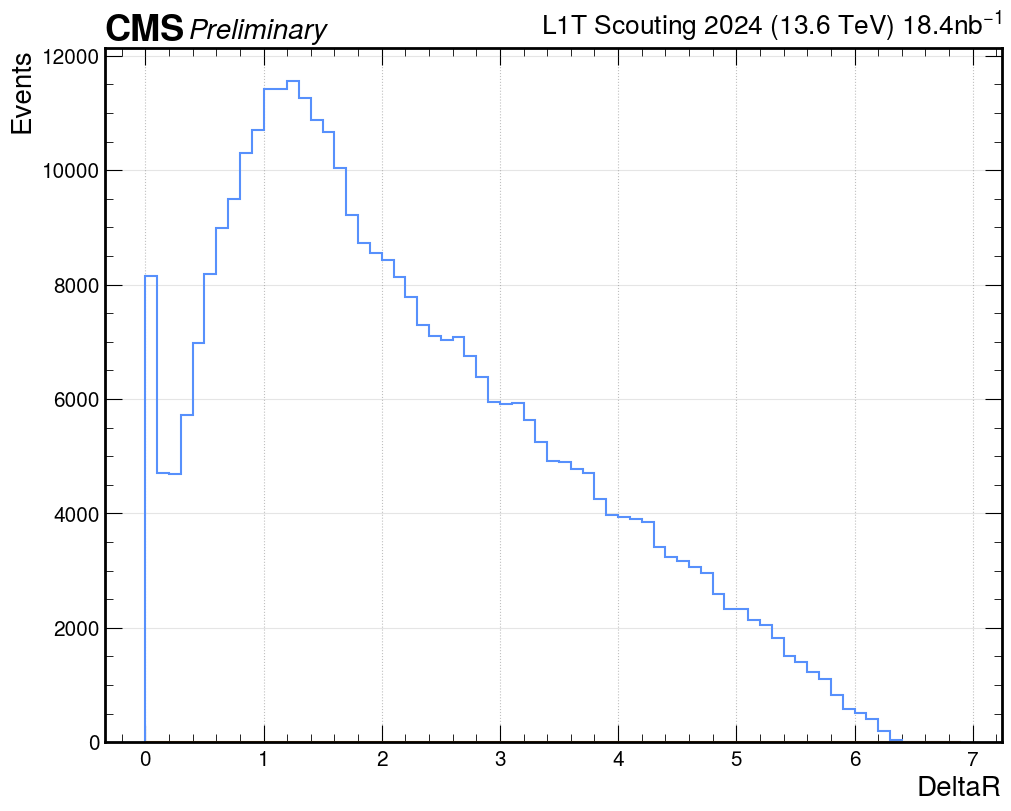

In [9]:
bins = np.arange(0, 7, 0.1)
DeltaRDist_HistBMTF = hist.Hist(hist.axis.Variable(bins, name="DeltaR", label="DeltaR"))
DeltaRDist_HistGMT = hist.Hist(hist.axis.Variable(bins, name="DeltaR", label="DeltaR"))

DeltaRDist_HistBMTF.fill(DeltaR = ak.flatten(MuonsEventsBMTF.DeltaR))
#DeltaRDist_HistGMT.fill(DeltaR = ak.flatten(MuonsEventsGMT.DeltaR))

fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE)

hep.histplot(DeltaRDist_HistBMTF, yerr = False)
hep.histplot(DeltaRDist_HistGMT, yerr = False)

ax.grid(True)
ax.legend(fontsize = FONTSIZE)
ax.set_ylabel("Events")
#ax.set_yscale('log')

ax.tick_params(axis='both', which='both', labelsize = FONTSIZE - 5)

plt.show()


In [10]:
def FilteredMuonsEvents(MuonsEvents, Th):

   MuonsDeltaR = MuonsEvents['DeltaR']
   MuonsPt = MuonsEvents['MuonProperty']['Pt']
   MuonsPtP1 = MuonsEvents['MuonP1Property']['Pt']
   MuonsPhi = MuonsEvents['MuonProperty']['Phi']
   MuonPhiP1 = MuonsEvents['MuonP1Property']['Phi']

   matched_copy = MuonsEvents['matched'].to_list()

   FinMuonsEvents = []

   for i in tqdm.tqdm(range(len(MuonsEvents))):
      matched_copy[i] = [False] * len(matched_copy[i])
      for j in range(len(matched_copy[i])):
         if ((MuonsDeltaR[i][j] < Th[0]) and (MuonsPt[i][j] > Th[1] and MuonsPtP1[i][j] > Th[2]) and (MuonsPhi[i][j] < Th[3] and MuonPhiP1[i][j] < Th[3])):
               matched_copy[i][j] = True

   MuonsEvents = ak.with_field(MuonsEvents, ak.Array(matched_copy), 'matched')

   mask = ak.all(MuonsEvents.matched, axis=-1)

   FinMuonsEvents = MuonsEvents[mask]

   return ak.Array(FinMuonsEvents)


In [11]:
FilMuonsEventsBMTF = FilteredMuonsEvents(MuonsEventsBMTF, [1, 50, 0, 0])
FilMuonsEventsGMT = FilteredMuonsEvents(MuonsEventsGMT, [1, 50, 0, 0])

100%|██████████| 350700/350700 [00:15<00:00, 22639.43it/s]


In [18]:
FilMuonsEventsGMT

<Array [{event: 72000, nMuons: 1, ...}, ...] type='82 * {event: int64, nMuo...'>

In [13]:
PtBMTF = FilMuonsEventsBMTF['MuonProperty']['Pt']
EtaBMTF = FilMuonsEventsBMTF['MuonProperty']['Eta']
PtP1BMTF = FilMuonsEventsBMTF['MuonP1Property']['Pt']
EtaP1BMTF = FilMuonsEventsBMTF['MuonP1Property']['Eta']

PtGMT = FilMuonsEventsGMT['MuonProperty']['Pt']
EtaGMT = FilMuonsEventsGMT['MuonProperty']['Eta']
PtP1GMT = FilMuonsEventsGMT['MuonP1Property']['Pt']
EtaP1GMT = FilMuonsEventsGMT['MuonP1Property']['Eta']

In [15]:
binsPt = np.arange(0, 255, 1)

PtDist_HistBMTF = hist.Hist(hist.axis.Variable(binsPt, name="Pt"))
PtP1Dist_HistBMTF = hist.Hist(hist.axis.Variable(binsPt, name="PtP1"))

PtDist_HistGMT = hist.Hist(hist.axis.Variable(binsPt, name="Pt"))
PtP1Dist_HistGMT = hist.Hist(hist.axis.Variable(binsPt, name="PtP1"))

PtDist_HistBMTF.fill(Pt = ak.flatten(PtBMTF))
PtP1Dist_HistBMTF.fill(PtP1 = ak.flatten(PtP1BMTF))

PtDist_HistGMT.fill(Pt = ak.flatten(PtGMT))
PtP1Dist_HistGMT.fill(PtP1 = ak.flatten(PtP1GMT))



Hist(Variable(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 145., 146., 147., 148., 149., 150., 151., 152., 153.,
       154., 155., 156., 157., 158., 159., 160., 161., 162., 163., 164.,
       165., 166., 167., 168., 169., 170., 171., 172., 173., 174., 175.,
       176., 177., 178., 179., 180., 181., 182., 183., 184., 185., 186.,
       187., 188., 189., 190., 191., 192., 193., 194., 195., 196., 197.,
       198., 199., 200., 201., 202., 203., 204., 205., 206., 207., 208.,
       209., 210., 211., 212., 213., 214., 215., 216., 217., 218., 219.,
       220., 221., 222., 223., 224., 225., 226., 227., 228., 229., 230.,
       231., 232., 233., 234., 235., 236., 237., 238., 239., 240., 241.,
       242., 243., 244., 245., 246., 247., 248., 249., 250., 251., 252.,
       253., 254.]), name='PtP1'), storage=Double()) # Sum: 82.0

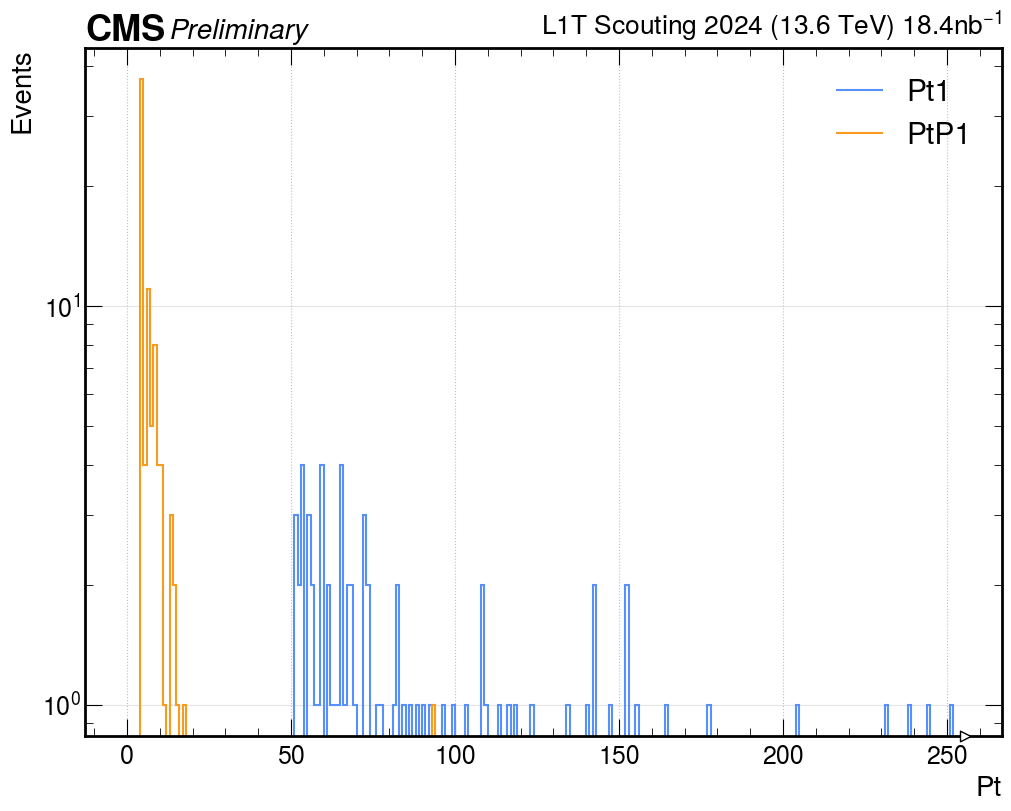

In [17]:
fig, ax = plt.subplots(figsize=FIGSIZE, constrained_layout=True)
set_label_font(ax, FONTSIZE)
set_tick_font(ax, FONTSIZE-2)
draw_grid(ax, axis="y")
draw_cms_label(ax, fontsize= FONTSIZE)

#hep.histplot(PtDist_HistBMTF, yerr = False, label="Pt1")
#hep.histplot(PtP1Dist_HistBMTF, yerr = False, label="PtP1")

hep.histplot(PtDist_HistGMT, yerr = False, label="Pt1")
hep.histplot(PtP1Dist_HistGMT, yerr = False, label="PtP1")


ax.grid(True)
ax.legend(fontsize = FONTSIZE)
ax.set_ylabel("Events")
ax.set_yscale('log')

ax.legend()